In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, AdamW
import torch.optim as optim

In [3]:
'''Large synthetic Dataset and gold'''

import pandas as pd
import numpy as np


def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# Read the CSV file into a DataFrame
file_names = ['data/large_dataset_v2.csv']
dfs = [pd.read_csv(example) for example in file_names]

# Initialize an empty list to store the transformed data
train_dataset = []

# Iterate through the rows of the DataFrame
# prefixing in urdu
for df in dfs:
  for index, row in df.iterrows():
      input_text = "جملے کی درستگی: " + row[0]
      output_text = row[1]

      # Create a dictionary for each example and append it to the train_dataset
      example = {"input": input_text, "output": output_text}
      train_dataset.append(example)
      #print(example)

gold_src_data = read_file('./data/gold/gold_src.txt')
gold_trg_data = read_file('./data/gold/gold_trg.txt')

                # Store data in the dictionary
for i in range(len(gold_src_data)):
    input_text = "جملے کی درستگی: " + gold_src_data[i].strip()
    output_text = gold_trg_data[i].strip()
    train_dataset.append({"input": input_text, "output": output_text})

print(len(train_dataset))

/tmp/ipykernel_2578729/1720850342.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_text = "جملے کی درستگی: " + row[0]
/tmp/ipykernel_2578729/1720850342.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_text = row[1]


32213


In [3]:
'''Train Dataset'''

#Data from urwiki
# import os
# import math

# directory_path = "data/out_R_filtered" 
# MAX_ERR_TYPE = math.inf


# def read_data_from_directory(directory_path):
#     train_data = []

#     # Iterate through all subdirectories and files
#     for root, dirs, files in os.walk(directory_path):
#         for file_name in files:
#             # Check if the file is a .src file
#             if file_name.endswith(".src"):
#                 src_file_path = os.path.join(root, file_name)

#                 # Create the corresponding .trg file path
#                 trg_file_path = os.path.join(root, file_name.replace(".src", ".trg"))

#                 # Read data from both .src and .trg files
#                 src_data = read_file(src_file_path)
#                 trg_data = read_file(trg_file_path)

#                 # Store data in the dictionary
#                 for i in range(min(len(src_data), MAX_ERR_TYPE)):
#                     input_text = "جملے کی درستگی: " + src_data[i].strip()
#                     output_text = trg_data[i].strip()
#                     train_data.append({"input": input_text, "output": output_text})
#     return train_data

# train_dataset = read_data_from_directory(directory_path)
# len(train_dataset)


7857

In [4]:
# model_name = "google/mt5-large"
# tokenizer = MT5Tokenizer.from_pretrained(model_name)
# model = MT5ForConditionalGeneration.from_pretrained(model_name)

model_path = "./finetuned_mt5_base_manual"
model = MT5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = MT5Tokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from tqdm import tqdm
import torch.nn.functional as F
import csv
from datetime import datetime
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts
import torch.utils.checkpoint as checkpoint
import os

# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
#optimizer = optim.SGD(model.parameters(), lr=1e-5)#, momentum=0.9, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

batch_size = 4
# Gradient accumulation
accumulation_steps = 4  # Accumulate gradients over 4 batches before updating

# Gradient clipping
max_grad_norm = 1.0  # Set your desired maximum gradient norm

# Mixed-precision training
scaler = GradScaler()

#model.enable_input_require_grads()
#torch.set_grad_enabled(True)  # Context-manager 

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}


def train(train_dataloader):
    global model
    global optimizer
    global scheduler

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        # max_length = max(inputs.size(1), labels.size(1))
        # inputs = F.pad(inputs, (0, max_length - inputs.size(1)))
        # labels = F.pad(labels, (0, max_length - labels.size(1)))

        optimizer.zero_grad()

        outputs = model(inputs, labels=labels)
        logits = outputs.logits

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)
        
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions


def train_mixed_precision(train_dataloader):
    global model
    global optimizer
    global scheduler
    global scaler
    global accumulation_steps
    global max_grad_norm

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        max_length = max(inputs.size(1), labels.size(1))
        inputs = F.pad(inputs, (0, max_length - inputs.size(1)))
        labels = F.pad(labels, (0, max_length - labels.size(1)))

        with autocast():  # Use mixed-precision training
            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            logits = outputs.logits

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # if (i + 1) % accumulation_steps == 0:
        #     scaler.unscale_(optimizer)  # Unscales the gradients of optimizer's assigned params in-place
        #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping
        #     scaler.step(optimizer)
        #     scaler.update()
        #     optimizer.zero_grad()   

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions

def train_checkpoint(train_dataloader):
    global model
    global optimizer
    global scheduler

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        optimizer.zero_grad()
        # Define the function that computes the forward pass
        def forward_pass(inputs, labels):
            outputs = model(inputs, labels=labels)
            logits = outputs.logits
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)
            return logits, loss

        # Use gradient checkpointing for the forward pass
        logits, loss = checkpoint.checkpoint(forward_pass, inputs, labels, use_reentrant=False)
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions

def validate(validation_dataloader):
    global model

    total_samples = 0
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for val_batch in validation_dataloader:
            val_inputs = val_batch[0]["input_ids"]
            val_labels = val_batch[1]["input_ids"]

            # max_length = max(val_inputs.size(1), val_labels.size(1))
            # val_inputs = F.pad(val_inputs, (0, max_length - val_inputs.size(1)))
            # val_labels = F.pad(val_labels, (0, max_length - val_labels.size(1)))

            val_outputs = model(val_inputs, labels=val_labels)
            val_logits = val_outputs.logits

            val_loss += F.cross_entropy(val_logits.view(-1, val_logits.size(-1)), val_labels.view(-1), ignore_index=tokenizer.pad_token_id).item()

            _, predicted_labels = torch.max(val_logits, dim=-1)
            correct_predictions += torch.sum(predicted_labels.view(-1) == val_labels.view(-1)).item()
            total_samples += val_labels.numel()

    return total_samples, val_loss, correct_predictions


def initialize_data(start, end):
    global train_dataset

    input_texts = [example["input"] for example in train_dataset[start:end]]
    target_texts = [example["output"] for example in train_dataset[start:end]]

    # train validation split
    split_ratio = 0.9
    train_size = int(split_ratio * len(input_texts))
    indices = np.arange(len(input_texts))
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_input_texts = [input_texts[i] for i in train_indices]
    train_target_texts = [target_texts[i] for i in train_indices]
    validation_input_texts = [input_texts[i] for i in val_indices]
    validation_target_texts = [target_texts[i] for i in val_indices]

    # custom datasets
    train_input_dataset = CustomDataset(train_input_texts, tokenizer)
    train_target_dataset = CustomDataset(train_target_texts, tokenizer)
    validation_input_dataset = CustomDataset(validation_input_texts, tokenizer)
    validation_target_dataset = CustomDataset(validation_target_texts, tokenizer)

    # Combine datasets for DataLoader
    train_combined_dataset = list(zip(train_input_dataset, train_target_dataset))
    train_dataloader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
    validation_combined_dataset = list(zip(validation_input_dataset, validation_target_dataset))
    validation_dataloader = DataLoader(validation_combined_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, validation_dataloader


# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
iterations = 1

for i in range(0, iterations):
    num_epochs = 100
    start_index = 0
    end_index = len(train_dataset)
    train_dataloader, validation_dataloader = initialize_data(start_index, end_index)

    for epoch in range(num_epochs):
        total_train_samples, total_loss, correct_train_predictions = train(train_dataloader)
        scheduler.step()

        #validation
        total_samples, val_loss, correct_predictions = validate(validation_dataloader)

        # Metrics
        average_train_loss = total_loss / len(train_dataloader)
        average_val_loss = val_loss / len(validation_dataloader)

        accuracy = correct_predictions / total_samples
        accuracy_train = correct_train_predictions / total_train_samples

        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)

        val_accuracies.append(accuracy)
        train_accuracies.append(accuracy_train)

        print(f"Train Loss: {average_train_loss}, Train accuracy: {accuracy_train}, Val Loss: {average_val_loss}, Val Accuracy: {accuracy}")

        if(epoch % 5 == 0 ):
            name = "./finetuned_mt5_base_manual+synthetic"
            model.save_pretrained(name)
            tokenizer.save_pretrained(name)
            print("Saved as ", name)

Epoch 1: 100%|██████████| 7248/7248 [23:48<00:00,  5.07it/s]


Train Loss: 0.5184743989212514, Train accuracy: 0.22400372370815042, Val Loss: 0.06051330829978627, Val Accuracy: 0.3472082303019202
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 2: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.05164529152804506, Train accuracy: 0.2445340745859694, Val Loss: 0.0357018731786955, Val Accuracy: 0.3494418495792248


Epoch 3: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.769488176950572, Train accuracy: 0.21420282235826657, Val Loss: 0.05396577590012289, Val Accuracy: 0.3477424672589065


Epoch 4: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.06480513770135321, Train accuracy: 0.24379464574221807, Val Loss: 0.04401594267654864, Val Accuracy: 0.34886690885408717


Epoch 5: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.03165260573313948, Train accuracy: 0.2455427110355691, Val Loss: 0.040387393346084655, Val Accuracy: 0.3491467472601276


Epoch 6: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.024195764505042516, Train accuracy: 0.24604504687740983, Val Loss: 0.03273240748233595, Val Accuracy: 0.3501796053769678
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 7: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.01841998660016577, Train accuracy: 0.24642883621829526, Val Loss: 0.03351676571569995, Val Accuracy: 0.35023048508715693


Epoch 8: 100%|██████████| 7248/7248 [23:59<00:00,  5.04it/s]


Train Loss: 0.015887101204064155, Train accuracy: 0.24662905689716627, Val Loss: 0.03029465842606243, Val Accuracy: 0.3505204994352352


Epoch 9: 100%|██████████| 7248/7248 [23:59<00:00,  5.03it/s]


Train Loss: 0.012397552007352411, Train accuracy: 0.2468847842988926, Val Loss: 0.03348935239819748, Val Accuracy: 0.35034242044957314


Epoch 10: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.010705613533716239, Train accuracy: 0.24695059941313535, Val Loss: 0.0326196648400754, Val Accuracy: 0.35032206856549747


Epoch 11: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.004925038553231206, Train accuracy: 0.24741606293193646, Val Loss: 0.033007857151687296, Val Accuracy: 0.35068840247885946
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 12: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.0031626892355079332, Train accuracy: 0.2475500720199729, Val Loss: 0.03191630062180072, Val Accuracy: 0.3508105137833135


Epoch 13: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.002609200534218184, Train accuracy: 0.24757465356866598, Val Loss: 0.03676575852879129, Val Accuracy: 0.35083086566738914


Epoch 14: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.002312031620174283, Train accuracy: 0.24758971967915527, Val Loss: 0.03658515572374538, Val Accuracy: 0.3506985784208973


Epoch 15: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.0022732679119296588, Train accuracy: 0.24760280340668547, Val Loss: 0.039533205325375874, Val Accuracy: 0.3507545461021054


Epoch 16: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.0019756453190690713, Train accuracy: 0.24761786951717477, Val Loss: 0.036407769135956065, Val Accuracy: 0.35068840247885946
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 17: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.001922438972405002, Train accuracy: 0.24761271532148107, Val Loss: 0.03833301678892123, Val Accuracy: 0.3508512175514648


Epoch 18: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.001999266020745929, Train accuracy: 0.24763055676811313, Val Loss: 0.03519709356896106, Val Accuracy: 0.3507545461021054


Epoch 19: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.0016955457672248962, Train accuracy: 0.24763769334676597, Val Loss: 0.03956821832072354, Val Accuracy: 0.3507494581310865


Epoch 20: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.0018132238992537865, Train accuracy: 0.24764126163609237, Val Loss: 0.03564141826864436, Val Accuracy: 0.35085630552248376


Epoch 21: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.0009252491959203196, Train accuracy: 0.24770073312486593, Val Loss: 0.04056762740905957, Val Accuracy: 0.35091736117471073
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 22: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 0.00038420992743749344, Train accuracy: 0.2477217463842326, Val Loss: 0.04239793966246015, Val Accuracy: 0.35079524987025673


Epoch 23: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 0.0006033155994152778, Train accuracy: 0.24771738514172253, Val Loss: 0.04714727346536541, Val Accuracy: 0.35087665740655943


Epoch 24: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.0003598155420991707, Train accuracy: 0.24773126182243638, Val Loss: 0.04823913960894623, Val Accuracy: 0.35087665740655943


Epoch 25: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 0.00037324803467522473, Train accuracy: 0.24772888296288542, Val Loss: 0.04720207424610651, Val Accuracy: 0.350902097261654


Epoch 26: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 0.0003489045342291769, Train accuracy: 0.24772967591606906, Val Loss: 0.04872723456238343, Val Accuracy: 0.35089700929063505
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 27: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 0.00024557938558049955, Train accuracy: 0.24773403715857914, Val Loss: 0.04417572684825489, Val Accuracy: 0.3508664814645216


Epoch 28: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.000338100016914728, Train accuracy: 0.24773086534584454, Val Loss: 0.04027715220067259, Val Accuracy: 0.3508715694355405


Epoch 29: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 0.00030983931049519185, Train accuracy: 0.2477332442053955, Val Loss: 0.040716336933389254, Val Accuracy: 0.3509071852326729


Epoch 30: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 0.00025127129837100446, Train accuracy: 0.24773641601813007, Val Loss: 0.04798801842904074, Val Accuracy: 0.3508461295804459


Epoch 31: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 0.00016267261652937778, Train accuracy: 0.2477399843074565, Val Loss: 0.04561586466871931, Val Accuracy: 0.35099876871101343
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 32: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 6.430085989914628e-05, Train accuracy: 0.24774553497974203, Val Loss: 0.047595564467138314, Val Accuracy: 0.35099876871101343


Epoch 33: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 3.6119041303064265e-05, Train accuracy: 0.2477467244095175, Val Loss: 0.05649600861332121, Val Accuracy: 0.3509885927689756


Epoch 34: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 5.90850163581891e-05, Train accuracy: 0.24774632793292567, Val Loss: 0.06281003953562075, Val Accuracy: 0.35094788900082424


Epoch 35: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 4.89393106209864e-05, Train accuracy: 0.2477471208861093, Val Loss: 0.07018494028622653, Val Accuracy: 0.3509377130587864


Epoch 36: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 2.8045176466189256e-05, Train accuracy: 0.2477467244095175, Val Loss: 0.06660145178379759, Val Accuracy: 0.3509071852326729
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 37: 100%|██████████| 7248/7248 [23:56<00:00,  5.04it/s]


Train Loss: 3.921771691159987e-05, Train accuracy: 0.24774751736270115, Val Loss: 0.09492445007349297, Val Accuracy: 0.35089700929063505


Epoch 38: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 2.0502963668685883e-05, Train accuracy: 0.2477483103158848, Val Loss: 0.06472131147942413, Val Accuracy: 0.3509071852326729


Epoch 39: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 1.929151996946878e-05, Train accuracy: 0.24774751736270115, Val Loss: 0.06916285520338505, Val Accuracy: 0.3509733288559188


Epoch 40: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 1.3548493355653685e-05, Train accuracy: 0.24774751736270115, Val Loss: 0.08068687622698575, Val Accuracy: 0.35089700929063505


Epoch 41: 100%|██████████| 7248/7248 [23:58<00:00,  5.04it/s]


Train Loss: 2.1007783083714488e-05, Train accuracy: 0.24774751736270115, Val Loss: 0.07591174281013988, Val Accuracy: 0.350902097261654
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 42: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 6.088589749832874e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.07818045639009888, Val Accuracy: 0.35092753711674857


Epoch 43: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 6.482621449413704e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.08453683807572022, Val Accuracy: 0.3509326250877675


Epoch 44: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.949578336737694e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.08829313213768832, Val Accuracy: 0.3509377130587864


Epoch 45: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 4.040459105979153e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.08559449942111716, Val Accuracy: 0.3509377130587864


Epoch 46: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.0412574639419186e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.09393724951197545, Val Accuracy: 0.3509529769718432
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 47: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 5.06253815935122e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.08606648369140674, Val Accuracy: 0.3509580649428621


Epoch 48: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.363663448886176e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.09205059038299382, Val Accuracy: 0.350963152913881


Epoch 49: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.466130703847628e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.08779640471507519, Val Accuracy: 0.3509580649428621


Epoch 50: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 5.0008751381722705e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.08675827158168627, Val Accuracy: 0.35094788900082424


Epoch 51: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 4.254136293400537e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.08986866854979354, Val Accuracy: 0.35094788900082424
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 52: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.060478590253572e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.08999444368347681, Val Accuracy: 0.3509529769718432


Epoch 53: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 2.8715458439618126e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.08944023320002205, Val Accuracy: 0.3509580649428621


Epoch 54: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.057461854147803e-06, Train accuracy: 0.2477483103158848, Val Loss: 0.09385497017513315, Val Accuracy: 0.3509529769718432


Epoch 55: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 4.780695474327429e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.09062033077459238, Val Accuracy: 0.3509580649428621


Epoch 56: 100%|██████████| 7248/7248 [23:56<00:00,  5.05it/s]


Train Loss: 2.741407799628722e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.09202289508878864, Val Accuracy: 0.3509580649428621
Saved as  ./finetuned_mt5_base_manual+synthetic


Epoch 57: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 3.4709574648580784e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.09697169999858435, Val Accuracy: 0.3509580649428621


Epoch 58: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 3.7132427693180277e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.0923877997528687, Val Accuracy: 0.3509580649428621


Epoch 59: 100%|██████████| 7248/7248 [23:55<00:00,  5.05it/s]


Train Loss: 3.210529146981577e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.10129488849995254, Val Accuracy: 0.3509529769718432


Epoch 60: 100%|██████████| 7248/7248 [23:57<00:00,  5.04it/s]


Train Loss: 3.3005851228454043e-06, Train accuracy: 0.24774870679247663, Val Loss: 0.09710100678923607, Val Accuracy: 0.3509529769718432


Epoch 61:  55%|█████▍    | 3952/7248 [13:03<10:53,  5.04it/s]


KeyboardInterrupt: 

In [14]:
torch.cuda.empty_cache()
optimizer.zero_grad()
torch.no_grad()

Plotting

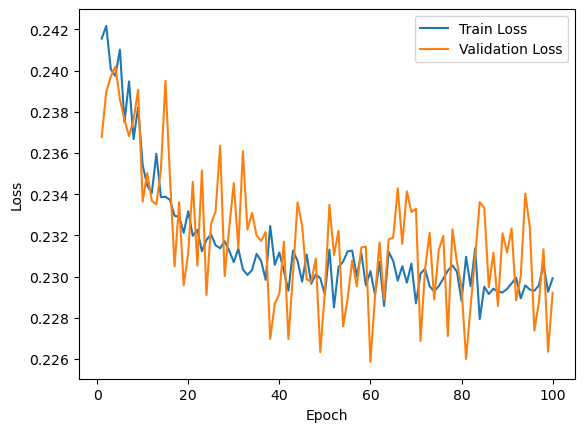

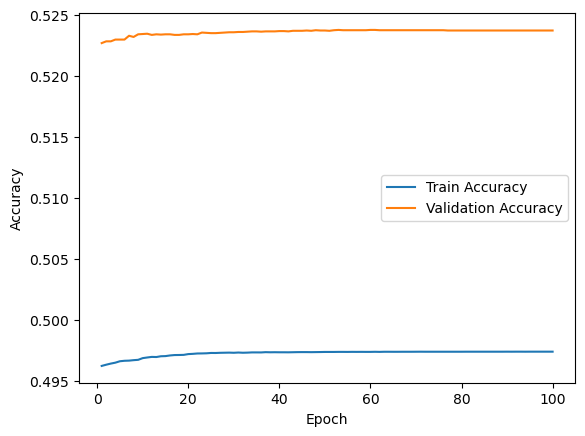

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs*iterations + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs*iterations + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs*iterations + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs*iterations + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
'''Testing'''

test_dataset?

def get_accuracy():
    pass

#F0.5, precision, recall, 

In [2]:
model_path = "./finetuned_mt5_base_manual+synthetic/"
model = MT5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = MT5Tokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [32]:
'''Demo'''

# model_path = "./finetuned_mt5_model"
# model = MT5ForConditionalGeneration.from_pretrained(model_path)
# tokenizer = MT5Tokenizer.from_pretrained(model_path)
# model.to(device)

input_sentences = [
                    'میری پیر جل رہی ہے۔',
                    'اس نے گھر جانا ہے',
                   'آپ کو تار ملی',
                   'آپ کی قلم کہاں ہے',
                   'امی ابو گھر پر نہیں ہے',
                   'طارق نے اخبار خریدی',
                   'میں جارہا تھی',
                    'اس لئے وہ پاگل ہے۔',
                    'وہ جارہا تھی'
                   ]



with open('output.txt', 'w', encoding='utf-8') as file:
  for input_sentence in input_sentences:
      print(f"{input_sentence}")
      file.write(f"{input_sentence}\n")

      input_ids = tokenizer.encode("جملے کی درستگی: " + input_sentence, return_tensors="pt", max_length=128, truncation=True).to(device)
      output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)
      for output_id in output_ids:
        corrected_sentence = tokenizer.decode(output_id, skip_special_tokens=True)
        print(f"{corrected_sentence}")
        file.write(f"{corrected_sentence}\n")
      print("")
      file.write("\n\n")


میری پیر جل رہی ہے۔
میرا پیر جل رہا ہے۔

اس نے گھر جانا ہے
اسے گھر جانا ہے

آپ کو تار ملی
آپ کا تار ملا۔

آپ کی قلم کہاں ہے
آپ کا قلم کہاں ہے؟

امی ابو گھر پر نہیں ہے
امی ابو گھر پر نہیں ہیں

طارق نے اخبار خریدی
طارق نے اخبار خریدا

میں جارہا تھی
میں جارہا تھا

اس لئے وہ پاگل ہے۔
اس لئے وہ پاگل ہے۔

وہ جارہا تھی
وہ جارہا تھا



In [16]:
# !pip install scikit-learn
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mh07607/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
import nltk
from nltk.translate import gleu_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import fbeta_score, precision_score, recall_score
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_sequences_to_max_length(sequences, max_length, padding_value):
    return pad_sequences(sequences, maxlen=max_length, padding='post', value=padding_value, dtype=object)

def calculate_gleu_score(reference, hypothesis):
    # Tokenize sentences into words
    # reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
    # hypothesis_tokens = [nltk.word_tokenize(sent) for sent in hypothesis]

    reference_tokens = []
    hypothesis_tokens = []
    for i in range(len(reference)):
        reference_sentence_token_list = nltk.word_tokenize(reference[i])
        hypothesis_sentence_token_list = nltk.word_tokenize(hypothesis[i])
        reference_tokens.append([reference_sentence_token_list])
        hypothesis_tokens.append(hypothesis_sentence_token_list)

    # Calculate GLEU score
    gleu = gleu_score.corpus_gleu(reference_tokens, hypothesis_tokens)
    return gleu

def calculate_f05_score(reference, hypothesis):
    # Tokenize sentences into words
    reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
    hypothesis_tokens = [nltk.word_tokenize(sent) for sent in hypothesis]

    max_length = max(max(len(tokens) for tokens in reference_tokens),
                    max(len(tokens) for tokens in hypothesis_tokens))

    # Pad sequences to the maximum length
    reference_padded = pad_sequences_to_max_length(reference_tokens, max_length, '<PAD>')
    hypothesis_padded = pad_sequences_to_max_length(hypothesis_tokens, max_length, '<PAD>')

    # Flatten the lists to get a list of all tokens
    reference_tokens_flat = [token for sent in reference_padded for token in sent]
    hypothesis_tokens_flat = [token for sent in hypothesis_padded for token in sent]

    # Convert tokens to lists for F0.5 calculation
    reference_list = list(reference_tokens_flat)
    hypothesis_list = list(hypothesis_tokens_flat)

    # Calculate F0.5 score
    f05 = fbeta_score(reference_list, hypothesis_list, beta=0.5, average='macro')

    return f05

def calculate_precision_recall(reference, hypothesis):
    # Tokenize sentences into words
    reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
    hypothesis_tokens = [nltk.word_tokenize(sent) for sent in hypothesis]

    max_length = max(max(len(tokens) for tokens in reference_tokens),
                    max(len(tokens) for tokens in hypothesis_tokens))

    # Pad sequences to the maximum length
    reference_padded = pad_sequences_to_max_length(reference_tokens, max_length, '<PAD>')
    hypothesis_padded = pad_sequences_to_max_length(hypothesis_tokens, max_length, '<PAD>')

    # Flatten the lists to get a list of all tokens
    reference_tokens_flat = [token for sent in reference_padded for token in sent]
    hypothesis_tokens_flat = [token for sent in hypothesis_padded for token in sent]

    # Convert tokens to lists
    reference_list = list(reference_tokens_flat)
    hypothesis_list = list(hypothesis_tokens_flat)

    # Calculate precision and recall
    precision = precision_score(reference_list, hypothesis_list, average='macro', zero_division=1)
    recall = recall_score(reference_list, hypothesis_list, average='macro', zero_division=1)

    return precision, recall


In [25]:
'''Computing scores'''

#Data from urwiki
import os
import math
from tqdm import tqdm

directory_path = "data/out_R_filtered" 

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

def compute_scores(directory_path, scores_file_name):
    # Iterate through all subdirectories and files
    for root, dirs, files in os.walk(directory_path):
        for file_name in files:
            # Check if the file is a .src file
            if file_name.endswith(".src"):
                src_file_path = os.path.join(root, file_name)

                # Create the corresponding .trg file path
                trg_file_path = os.path.join(root, file_name.replace(".src", ".trg"))

                # Read data from both .src and .trg files
                src_data = read_file(src_file_path)
                trg_data = read_file(trg_file_path)

                reference_sentences = []
                hypothesis_sentences = []

                for i in tqdm(range(len(src_data)), desc=f"Processing {file_name}"):
                    input_text = "جملے کی درستگی: " + src_data[i].strip()
                    reference_sentences.append(trg_data[i].strip())

                    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
                    output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)                        
                    hypothesis_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
                    hypothesis_sentences.append(hypothesis_sentence)

                total_gleu_score = calculate_gleu_score(reference_sentences, hypothesis_sentences)
                total_f05_score = calculate_f05_score(reference_sentences, hypothesis_sentences)
                total_precision, total_recall = calculate_precision_recall(reference_sentences, hypothesis_sentences)

                with open(scores_file_name, 'a', encoding='utf-8') as scores_file:
                    scores_file.write(f"Error_type: {file_name}\n")
                    scores_file.write(f"GLEU Score: {total_gleu_score}\n")
                    scores_file.write(f"F0.5 Score: {total_f05_score}\n")
                    scores_file.write(f"Precision: {total_precision}\n")
                    scores_file.write(f"Recall: {total_recall}\n\n")

compute_scores(directory_path, "scores.txt")

Processing R_PRON_INFL.src: 100%|██████████| 717/717 [04:39<00:00,  2.56it/s]
